Intro


There are 3 aggregated reasons of Churn (resignation of service by client) defined by Payability customer service:
    1. No longer active on Amazon (27% last 12 mths)
        I. Supplier’s sales decline, leading to end of business
    2. Outgrew Payability (27% last 12 mths)
        I. Supplier’s sales significantly incline and Supplier is getting other financing
    3. Product complaint (46% last 12 mths)
Task

Analyse first 2 points of above Churn reasons.

Having sales history data, prepare a model classifying the trend of sales as inclining or declining [or any other you see useful] and test the accuracy of model on given dataset. Check whether is there correlation of trend movement to churn event (churn happened if there is a date given in churn dataset – if there is no date, the client is still using our service) – verify the hipothesis stated by Customer Service.

Provide GitHub (or any similar, BitBucket etc.) link to Python script that you created during the analysis.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
import multiprocessing as mp 

In [2]:
#load the data
perf = pd.read_csv('seller_performance_data.csv', sep=';', low_memory=False).drop('Unnamed: 0', axis = 1)
churn = pd.read_csv('churn_data.csv', sep=';').drop('Unnamed: 0', axis = 1)

In [3]:
#set the right dtypes
perf.report_date = pd.to_datetime(perf.report_date)
churn.churn_date = pd.to_datetime(churn.churn_date)

perf.ordered_product_sales = perf.ordered_product_sales.apply(lambda x: 
                                                str(x).replace(',','.')).astype('float32')
perf.ordered_product_sales_b2b = perf.ordered_product_sales_b2b.apply(lambda x: 
                                                str(x).replace(',','.')).astype('float32')

# Overall Checks

Do we have performance data for all clients who did quit?

In [4]:
round(len(perf.loc[perf.supplier_key.isin(churn.supplier_key),'supplier_key'].unique()) / \
len(churn.supplier_key.unique()),3)

0.901

Around 10% of performance data is missing. Let's find out who those are.

In [5]:
set(churn.supplier_key.unique()).difference(set(perf.supplier_key.unique()))

{'093222f2-0030-4b9f-833e-b1395b1cf824',
 '2c624e3d-30a6-4328-9767-c78100ab26c7',
 '4408ef25-a930-42c2-9036-d2a73dba06f0',
 '45cdfd3b-7092-4e6f-a373-8f384a7f4304',
 '6d8136e4-8c5a-43f4-9d66-4c284766a81a',
 '6f9fbc7d-23fc-4a13-9223-971ec59ea175',
 '7a32a17c-3b0a-41ca-ae95-ce6b76e85dea',
 '815c6552-086b-420f-bd78-989254bcb34d',
 '898b3237-3a03-459f-b1e0-b4e285aaeedd',
 'a776a378-a343-4286-98a3-6675d68e2f51',
 'cb87344a-5db9-45c0-9c54-e7dd285faeee',
 'da98671d-70b6-44e0-9cc3-00d681092bb3',
 'f3501f9c-70c0-40d6-ba0c-e679b30e7e74',
 'fa2e1a47-ba8a-4f12-b117-f11ec117a4ef'}

Let's have a look at the data

In [6]:
perf.describe()

,ordered_product_sales,ordered_product_sales_b2b,units_ordered,units_ordered_b2b,units_refunded
count,278975.000000,278975.000000,278975.000000,278975.000000,278975.000000
mean,931.690002,27.646441,37.082502,1.036233,0.755806
std,4914.086426,330.797028,271.206070,14.744259,7.888461
min,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.980000,0.000000,1.000000,0.000000,0.000000
75%,397.769989,0.000000,14.000000,0.000000,0.000000
max,307322.437500,16839.220703,24333.000000,1867.000000,1582.000000


In [7]:
churn.describe()

,supplier_key,churn_date
count,141,141
unique,141,131
top,0ae8714c-f0fb-4f71-a23a-e9f3c4f327b9,2018-02-15 00:00:00
freq,1,4
first,NaN,2016-01-25 00:00:00
last,NaN,2018-11-16 00:00:00


The best way to see what's going on shortly before some clients quit is to plot the revenue against the time 

In [8]:
jdf = pd.merge(perf, churn, on = 'supplier_key', how = 'left')
jdf['days_to_churn'] = jdf.churn_date - jdf.report_date
jdf['days_to_churn'] = jdf['days_to_churn'].apply(lambda x: x.days)
jdf = jdf.loc[~jdf['days_to_churn'].isnull(),:]
jdf = jdf.loc[jdf['days_to_churn'] >= 0,:]
jdf.shape

(109383, 9)

Text(0, 0.5, 'Mean Sales')

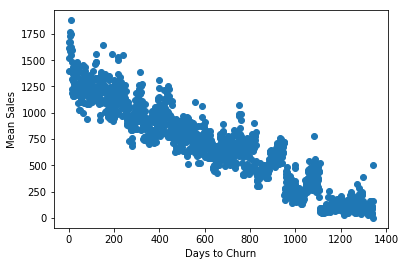

In [9]:
plt.scatter(jdf.groupby('days_to_churn').mean().index, \
            jdf.groupby('days_to_churn').mean()['ordered_product_sales'])
plt.xlabel('Days to Churn')
plt.ylabel('Mean Sales')

There seems to be a corelation between number of days left to quit and mean sales value but it's weirdly linear. Let's plot few individual examples.

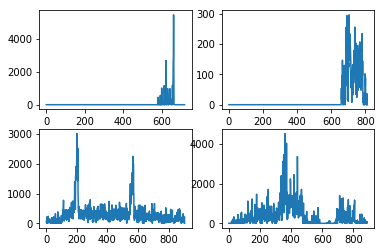

In [10]:
jdf = jdf.sort_values(by=['supplier_key','report_date']).reset_index()
plt.subplot(2, 2, 1)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique() \
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 2)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 3)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 4)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)


There are zeros at the beginning of some of time series. They should be removed.

In [11]:
jdf.drop('index', axis = 1, inplace=True)
jdf.loc[:,'beginZero'] = 0

In [12]:
def removeZeros(i):
        if (i == 0) & (jdf.loc[jdf.index == i,'ordered_product_sales'].values == 0):
            return pd.DataFrame(
                    [[
                      jdf.loc[jdf.index == i,'supplier_key'].values[0],
                        jdf.loc[jdf.index == i,'report_date'].values[0],
                        #jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                        1
                    ]],
            columns=['supplier_key','report_date','beginZero'])
        if jdf.loc[jdf.index == i,'supplier_key'].values == jdf.loc[jdf.index == i-1,'supplier_key'].values:
            if (jdf.loc[jdf.index == i,'ordered_product_sales'].values == 0) & \
            (jdf.loc[jdf.index == (i-1),'ordered_product_sales'].values == 0):  
                return pd.DataFrame(
                        [[
                          jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            #jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                            1
                        ]],
                columns=['supplier_key','report_date','beginZero'])
            else:
                return pd.DataFrame(
                        [[
                          jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            #jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                            0
                        ]],
                columns=['supplier_key','report_date','beginZero'])
        else:
            if (jdf.loc[jdf.index == i,'ordered_product_sales'].values == 0):
                return pd.DataFrame(
                        [[
                          jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            #jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                            1
                        ]],
                columns=['supplier_key','report_date','beginZero'])
            else:
                return pd.DataFrame(
                            [[
                              jdf.loc[jdf.index == i,'supplier_key'].values[0],
                            jdf.loc[jdf.index == i,'report_date'].values[0],
                            #jdf.loc[jdf.index == i,'ordered_product_sales'].values[0],
                                0
                            ]],
                    columns=['supplier_key','report_date','beginZero'])
 

In [13]:
%%time
pool = mp.Pool(processes = (mp.cpu_count()))
results = pool.map(removeZeros, range(jdf.shape[0]))
pool.close()
pool.join()

resdf = pd.concat(results)

CPU times: user 36.2 s, sys: 354 ms, total: 36.6 s
Wall time: 54.4 s


In [14]:
jdf = pd.merge(jdf,resdf, on = ['supplier_key','report_date'], suffixes=['_toDel',''])
jdf.drop(['beginZero_toDel'], axis = 1, inplace=True)
jdf = jdf.loc[jdf.beginZero == 0,:]

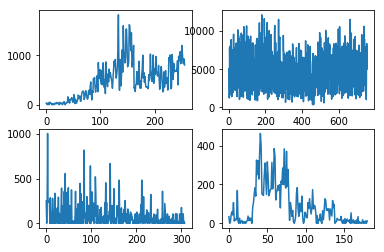

In [15]:
plt.subplot(2, 2, 1)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique() \
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 2)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 3)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)

plt.subplot(2, 2, 4)
plt.plot(jdf.loc[jdf.supplier_key == jdf.supplier_key.unique()\
                 [np.random.randint(len(jdf.supplier_key.unique()))],'ordered_product_sales'].values)


Now it's better. So, does Time looks in relation to Sales now?

Text(0, 0.5, 'Sales')

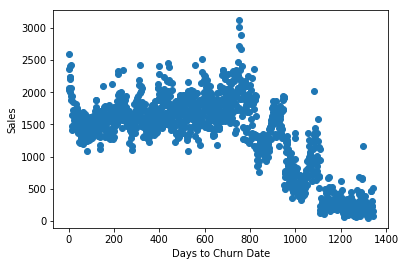

In [16]:
#inclines and declines cancel each either out?
plt.scatter(jdf.groupby('days_to_churn').mean().index, jdf.groupby('days_to_churn').mean() \
            ['ordered_product_sales'])
plt.xlabel('Days to Churn Date')
plt.ylabel('Sales')

Around 750 days before churn date mean sale peaks and slightly declines. Probably something do to with client acquisition. Also, if the assumption is some of the clients quit because and incline of sales the average is roughly stable, then there have to some clients getting down.

Text(0, 0.5, 'Sales')

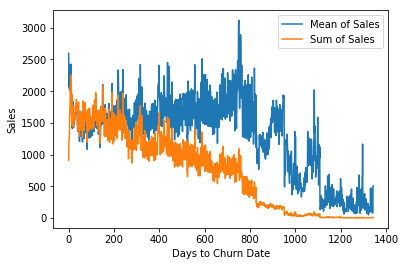

In [17]:
#inclines and declines cancel each either out?
plt.plot(jdf.groupby('days_to_churn').mean()['ordered_product_sales'])
plt.plot(jdf.groupby('days_to_churn').sum()['ordered_product_sales']/100)
plt.legend(['Mean of Sales', 'Sum of Sales'])
plt.xlabel('Days to Churn Date')
plt.ylabel('Sales')

Indeed. Sum is growning. Let's try to separate them, but before that we will aggregate the data by weekly basis. It will reduce the weekly seasonality and make the whole set more stable. 

Also,the plot is hardly readable so let's aggregate it on weekly basis. It will also remove the weekly seasonality and make the sales more stable.

In [18]:
jdf['year'] = jdf.report_date.dt.year
#jdf['month'] = jdf.report_date.dt.month
jdf['weekofyear'] = jdf.report_date.dt.weekofyear
# jdf['quarter'] = jdf.report_date.dt.quarter

In [19]:
jdfm = jdf.groupby(['supplier_key', 'year', 'weekofyear']).sum()
jdfm.drop(['days_to_churn', 'beginZero'], axis = 1, inplace=True)
jdfm = jdfm.reset_index().merge(churn, on = ['supplier_key'], how = 'left')

In [20]:
#weeks to churn
jdfm['weeks_to_churn'] = (jdfm.churn_date.dt.year - jdfm.year)*52 - \
    jdfm.weekofyear + jdfm.churn_date.dt.weekofyear

#weeks from start
jdfm['date'] = jdfm.year.map(str) + '-' + jdfm.weekofyear.map(str) + '-' + str(1)
#verify!
jdfm['date'] = pd.to_datetime(jdfm['date'], format='%Y-%W-%w')
jdfm['date'] = jdfm.supplier_key.map(jdfm.groupby('supplier_key').min()['date'])
jdfm['weeks_from_start'] = (jdfm.year*52 + jdfm.weekofyear) - (jdfm.date.dt.year*52 + jdfm.date.dt.weekofyear)
jdfm.drop('date', axis = 1, inplace=True)

Text(0, 0.5, 'Sales')

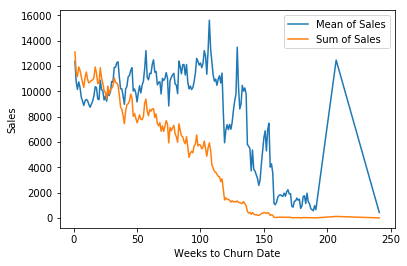

In [21]:
#cancel each either out?
plt.plot(jdfm.loc[jdfm.weeks_to_churn > 0,:].groupby('weeks_to_churn').mean()['ordered_product_sales'])
plt.plot(jdfm.loc[jdfm.weeks_to_churn > 0,:].groupby('weeks_to_churn').sum()['ordered_product_sales']/100)
plt.legend(['Mean of Sales', 'Sum of Sales'])
plt.xlabel('Weeks to Churn Date')
plt.ylabel('Sales')

It's defininately more clean now, the nature of the data seems to be in place though.

Now we will prepare some features describing the trend

In [22]:
jdfm = jdfm.set_index(['supplier_key', 'year','weekofyear'])
jdfm_diff = (jdfm - jdfm.groupby('supplier_key').shift(1))
jdfm_diff = jdfm_diff.reset_index()
jdfm = jdfm.reset_index()

for s in jdfm_diff.supplier_key.unique():
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'1wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(1).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'2wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(2).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'3wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(3).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'6wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(6).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'9wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(9).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'12wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(12).mean()
    jdfm_diff.loc[jdfm_diff.supplier_key == s,'15wDiffMean'] = \
        jdfm_diff.loc[jdfm_diff.supplier_key == s,'ordered_product_sales'].rolling(15).mean()
    
jdfm['1wDiffMean'] = jdfm_diff.loc[:,'1wDiffMean']
jdfm['2wDiffMean'] = jdfm_diff.loc[:,'2wDiffMean']
jdfm['3wDiffMean'] = jdfm_diff.loc[:,'3wDiffMean']
jdfm['6wDiffMean'] = jdfm_diff.loc[:,'6wDiffMean']
jdfm['9wDiffMean'] = jdfm_diff.loc[:,'9wDiffMean']
jdfm['12wDiffMean'] = jdfm_diff.loc[:,'12wDiffMean']
jdfm['15wDiffMean'] = jdfm_diff.loc[:,'15wDiffMean']

and try to see if we can separate successfully. Trend equal to 1 means we have a posisitive X week difference mean.

In [23]:
jdfm['trend'] = 0
jdfm['trend'].value_counts()
jdfm.loc[(jdfm.weeks_to_churn == 1) & (jdfm.loc[:,'6wDiffMean'] > 0),'trend'] = 1
jdfm = jdfm.reset_index()
jdfm.loc[:,'trend'] = jdfm.supplier_key.map(jdfm.groupby('supplier_key').max()['trend'])

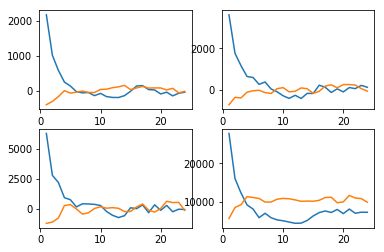

In [24]:
plt.subplot(2, 2, 1)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['12wDiffMean'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['12wDiffMean'])


plt.subplot(2, 2, 2)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['6wDiffMean'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['6wDiffMean'])

plt.subplot(2, 2, 3)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['3wDiffMean'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['3wDiffMean'])

plt.subplot(2, 2, 4)
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 1) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['ordered_product_sales'])
plt.plot(jdfm.loc[(jdfm.weeks_to_churn > 0) & (jdfm.trend == 0) & \
                  (jdfm.weeks_to_churn < 25),:].groupby('weeks_to_churn').mean()['ordered_product_sales'])

Well, clearly in the end the is a distinction. Let's add few more features and try to build a model around it.

In [25]:
for s in jdfm.supplier_key.unique():
    tsl = jdfm.loc[jdfm.supplier_key == s,:].shape[0]
    tsdf = jdfm.loc[jdfm.supplier_key == s,:]
    tslistmax = list()
    tslistmin = list()
    for l in range(tsl):
        tslistmax.append(tsdf.iloc[0:l,:].loc[:,'ordered_product_sales'].max())
        tslistmin.append(tsdf.iloc[0:l,:].loc[:,'ordered_product_sales'].min())
    jdfm.loc[jdfm.supplier_key == s,'peakSales'] = tslistmax
    jdfm.loc[jdfm.supplier_key == s,'peakSalesMin'] = tslistmin

jdfm['diffPeakMax'] = jdfm['ordered_product_sales'] - jdfm['peakSales']
jdfm['diffPeakMin'] = jdfm['ordered_product_sales'] - jdfm['peakSalesMin']

for s in jdfm.supplier_key.unique():
    jdfm.loc[jdfm.supplier_key == s,'3wMean_of_12wDiffMean'] = \
        jdfm.loc[jdfm.supplier_key == s,'12wDiffMean'].rolling(3).mean()

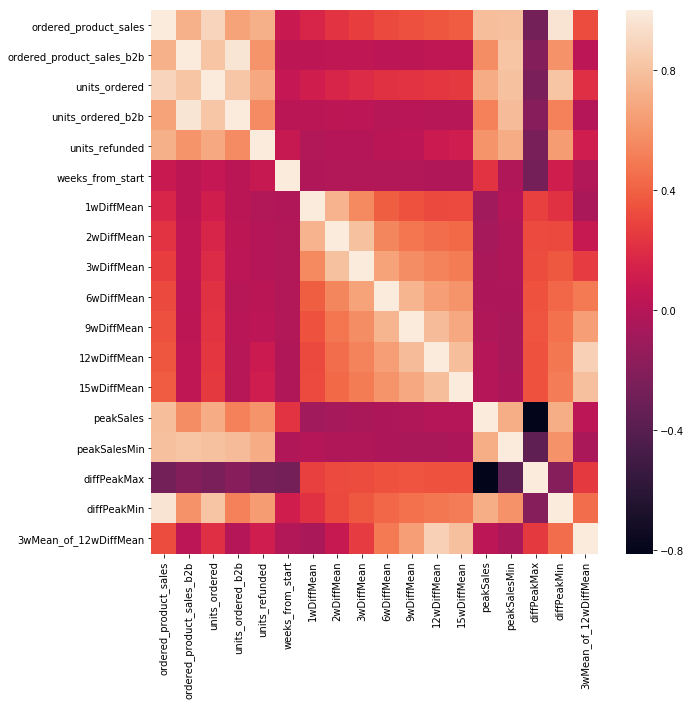

In [26]:
import seaborn as sns

cols_to_exclude = ['supplier_key',
            'year', 'weekofyear', 'index', 'churn_date', 'churned', 'weeks_to_churn', 'trend',
                  '%change1wVs3DiffMean','%change1wVs1DiffMean',
                  '%change1w_3mean','losingStrike','winningStrike']
cols = [c for c in jdfm.columns if c not in cols_to_exclude]

corr = jdfm[cols].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax = ax)

In [27]:
jdfm.loc[:,[c for c in jdfm.columns if 'Diff' in c]].corr()

,1wDiffMean,2wDiffMean,3wDiffMean,6wDiffMean,9wDiffMean,12wDiffMean,15wDiffMean,3wMean_of_12wDiffMean
1wDiffMean,1.000000,0.735219,0.555913,0.385945,0.347230,0.311875,0.316313,-0.047501
2wDiffMean,0.735219,1.000000,0.801375,0.542241,0.477300,0.441935,0.431241,0.078454
3wDiffMean,0.555913,0.801375,1.000000,0.665370,0.569160,0.528194,0.499595,0.257412
6wDiffMean,0.385945,0.542241,0.665370,1.000000,0.740294,0.643930,0.597620,0.493424
9wDiffMean,0.347230,0.477300,0.569160,0.740294,1.000000,0.774103,0.683679,0.644756
12wDiffMean,0.311875,0.441935,0.528194,0.643930,0.774103,1.000000,0.787570,0.869440
15wDiffMean,0.316313,0.431241,0.499595,0.597620,0.683679,0.787570,1.000000,0.790290
3wMean_of_12wDiffMean,-0.047501,0.078454,0.257412,0.493424,0.644756,0.869440,0.790290,1.000000


# RMSE Model

In [28]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [29]:
params = {
    'objective' :'regression',
    'learning_rate' : 0.1,
    'max_depth': 3,
    'num_leaves' : 3,
    'feature_fraction': 1, 
    'bagging_fraction': 0.7, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'rmse'
}

def model4JDFM(params, df, target, nr_fold=5, random_state=1):
    
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros(len(df))
    for fold_, (trn_, val_) in enumerate(folds.split(target, target)):
        trn_x, trn_y = df.iloc[trn_], target.iloc[trn_]
        val_x, val_y = df.iloc[val_], target.iloc[val_]
        
        # making lgbm datasets for train and valid
        d_train = lgbm.Dataset(trn_x, trn_y)
        d_valid = lgbm.Dataset(val_x, val_y)
        
        evals_result = {}
        # training with early stop
        clf = lgbm.train(params, d_train, 500, 
                 valid_sets=[d_train,d_valid], 
                 evals_result=evals_result,
                 verbose_eval=100, 
                 early_stopping_rounds=50)
        
        ax = lgbm.plot_metric(evals_result, metric='rmse')
        plt.show()
    
        clfs.append(clf)

        #oof_preds[val_] = clf.predict(val_x)
        print('no {}-fold loss: {}'.format(fold_ + 1, 
              rmse(val_y, clf.predict(val_x))))
        
        oof_preds[val_] = clf.predict(val_x)
    
        imp_df = pd.DataFrame({
                'feature': clf.feature_name(),
                'gain': clf.feature_importance(),
                'fold': [fold_ + 1] * len(df.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = rmse(target, oof_preds)
    print('rmse : {:.5f}'.format(score))
    #df_importances = save_importances(importances_=importances)
    #df_importances.to_csv('gbm_importances.csv', index=False)
    
    return clfs, score, importances, oof_preds

In [30]:
cols_to_exclude = ['supplier_key', 'level_0',
            'year', 'weekofyear', 'index', 'churn_date', 'churned', 'weeks_to_churn', 'trend',
                  '%change1wVs3DiffMean','diffPeakMin','diffPeakMax','%change1wVs1DiffMean',
                  '%change1w_3mean','losingStrike','winningStrike','3wMean_of_12wDiffMean','timeToPeakSales']
cols = [c for c in jdfm.columns if c not in cols_to_exclude]
jdfm_tr = jdfm.loc[(jdfm.weeks_to_churn > 0),:]
target = jdfm_tr.weeks_to_churn.copy()
#target.loc[target > 104] = 105
jdfm_tr = jdfm_tr[cols]

/home/showletter/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 28.9644	valid_1's rmse: 29.5106
[200]	training's rmse: 26.4427	valid_1's rmse: 27.5639
[300]	training's rmse: 24.8318	valid_1's rmse: 26.4956
[400]	training's rmse: 23.5311	valid_1's rmse: 25.8661
[500]	training's rmse: 22.5984	valid_1's rmse: 25.2849
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 22.5984	valid_1's rmse: 25.2849


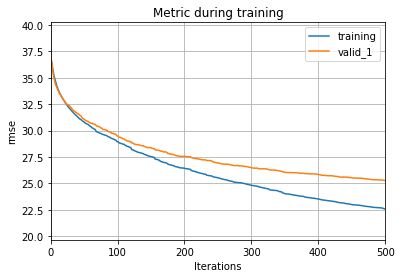

no 1-fold loss: 25.28490155901871
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 28.4328	valid_1's rmse: 32.5172
[200]	training's rmse: 25.7603	valid_1's rmse: 30.1636
[300]	training's rmse: 24.2774	valid_1's rmse: 29.2302
[400]	training's rmse: 23.2224	valid_1's rmse: 28.5812
[500]	training's rmse: 22.4489	valid_1's rmse: 28.1802
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 22.4489	valid_1's rmse: 28.1802


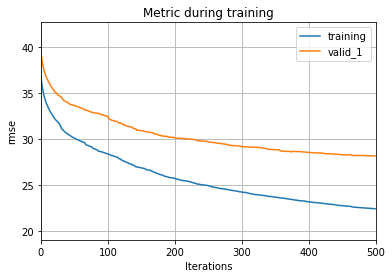

no 2-fold loss: 28.180179660940006
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 29.1715	valid_1's rmse: 28.4265
[200]	training's rmse: 26.6269	valid_1's rmse: 26.9421
[300]	training's rmse: 24.8597	valid_1's rmse: 25.4521
[400]	training's rmse: 23.732	valid_1's rmse: 24.8053
[500]	training's rmse: 22.918	valid_1's rmse: 24.2765
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 22.918	valid_1's rmse: 24.2765


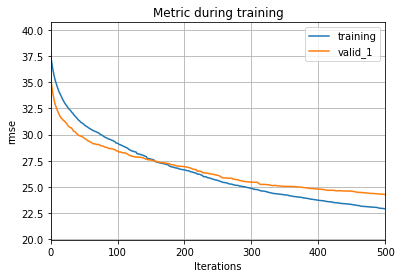

no 3-fold loss: 24.276547641323305
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 28.3562	valid_1's rmse: 33.0081
[200]	training's rmse: 25.8968	valid_1's rmse: 29.321
[300]	training's rmse: 24.5399	valid_1's rmse: 28.4598
[400]	training's rmse: 23.5328	valid_1's rmse: 27.9799
[500]	training's rmse: 22.6622	valid_1's rmse: 27.6357
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 22.6622	valid_1's rmse: 27.6357


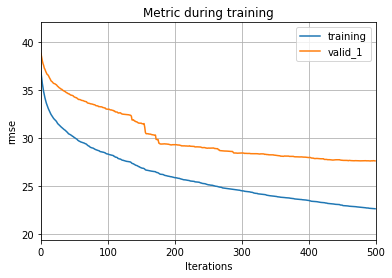

no 4-fold loss: 27.63571893480096
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 29.0825	valid_1's rmse: 28.4018
[200]	training's rmse: 26.877	valid_1's rmse: 27.1836
[300]	training's rmse: 25.138	valid_1's rmse: 26.104
[400]	training's rmse: 23.9332	valid_1's rmse: 25.5549
[500]	training's rmse: 22.9076	valid_1's rmse: 24.8659
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 22.9076	valid_1's rmse: 24.8659


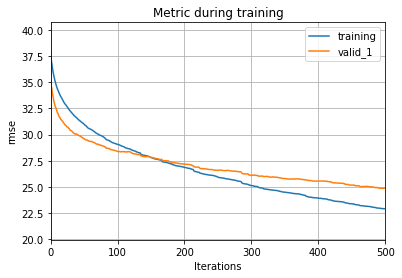

no 5-fold loss: 24.86585686359035
rmse : 26.11071


In [31]:
clfs, score, importances, oof_preds = model4JDFM(params, jdfm_tr, target, nr_fold=5, random_state=1)

In [32]:
importances.groupby('feature').mean().sort_values('gain', ascending = False)

,gain,fold
feature,,
peakSalesMin,326.2,3.0
peakSales,304.4,3.0
weeks_from_start,135.0,3.0
units_ordered,49.8,3.0
ordered_product_sales,40.4,3.0
units_refunded,27.4,3.0
15wDiffMean,20.6,3.0
ordered_product_sales_b2b,20.0,3.0
1wDiffMean,16.4,3.0


In [33]:
jdfm_tr['preds'] = oof_preds
jdfm_tr['weeks_to_churn'] = target

Text(0, 0.5, 'Weeks to churn PRED')

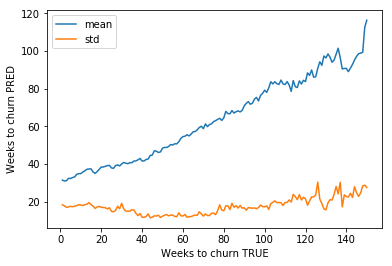

In [34]:
plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 151,:].groupby('weeks_to_churn').mean()['preds'])
plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 151,:].groupby('weeks_to_churn').std()['preds'])
plt.legend(['mean', 'std'])
plt.xlabel('Weeks to churn TRUE')
plt.ylabel('Weeks to churn PRED')

RMSE of 26 does look pretty bad though the prediction is correlated with true values. It could be potentially used as a hint or high level filter of some sort.

In [35]:
rmseCorr = jdfm_tr.loc[jdfm_tr.weeks_to_churn < 1151,:].groupby('weeks_to_churn').mean()['preds'].to_frame()
rmseCorr['ind'] = rmseCorr.index
rmseCorr.corr()

,preds,ind
preds,1.000000,0.927235
ind,0.927235,1.000000


Let's shift out focus to week before a client quit and see if we can predict just that.

# Model for AUC

In [36]:
cols_to_exclude = ['supplier_key',
            'year', 'weekofyear', 'index', 'churn_date', 'churned', 'weeks_to_churn', 'trend',
                  'ordered_product_sales_b2b','15wDiffMean','units_ordered_b2b','units_refunded',
                  '%change1wVs1DiffMean','%change1w_3mean','losingStrike','winningStrike','diffPeakMin',
                  'peakSales','level_0','6wMean','3wMean','12wMean','diffOf12wMean','timeToPeakSales']
cols = [c for c in jdfm.columns if c not in cols_to_exclude]
jdfm_tr = jdfm.loc[jdfm.weeks_to_churn > 0,:]
target = jdfm_tr.weeks_to_churn.copy()
target_ori = jdfm_tr.weeks_to_churn.copy()
trend = jdfm_tr.trend.copy()
jdfm_tr = jdfm_tr[cols]
target.loc[target > 1] = 0

params = {
    'objective' :'binary',
    'learning_rate' : 0.1,
    'max_depth': 3,
    'num_leaves' : 3,
    'feature_fraction': 1, 
    'bagging_fraction': 0.6, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'auc',
    'lambda_l1': 0,
    'lambda_l2': 0
}

def model4JDFM_AUC(params, df, target, nr_fold=5, random_state=1):
    
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros(len(df))
    for fold_, (trn_, val_) in enumerate(folds.split(target, target)):
        trn_x, trn_y = df.iloc[trn_], target.iloc[trn_]
        val_x, val_y = df.iloc[val_], target.iloc[val_]
        
        # making lgbm datasets for train and valid
        d_train = lgbm.Dataset(trn_x, trn_y)
        d_valid = lgbm.Dataset(val_x, val_y)
        
        evals_result = {}
        # training with early stop
        clf = lgbm.train(params, d_train, 500, 
                 valid_sets=[d_train,d_valid], 
                 evals_result=evals_result,
                 verbose_eval=10, 
                 early_stopping_rounds=50)
        
        ax = lgbm.plot_metric(evals_result, metric='auc')
        plt.show()
    
        clfs.append(clf)

        #oof_preds[val_] = clf.predict(val_x)
        print('no {}-fold AUC: {}'.format(fold_ + 1, 
              roc_auc_score(val_y, clf.predict(val_x))))
        
        oof_preds[val_] = clf.predict(val_x)
    
        imp_df = pd.DataFrame({
                'feature': clf.feature_name(),
                'gain': clf.feature_importance(),
                'fold': [fold_ + 1] * len(df.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = roc_auc_score(target, oof_preds)
    print('AUC : {:.5f}'.format(score))
    #df_importances = save_importances(importances_=importances)
    #df_importances.to_csv('gbm_importances.csv', index=False)
    
    return clfs, score, importances, oof_preds

Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.787208	valid_1's auc: 0.732691
[20]	training's auc: 0.832298	valid_1's auc: 0.785966
[30]	training's auc: 0.841374	valid_1's auc: 0.782007
[40]	training's auc: 0.861932	valid_1's auc: 0.769871
[50]	training's auc: 0.885216	valid_1's auc: 0.75076
[60]	training's auc: 0.896674	valid_1's auc: 0.744361
Early stopping, best iteration is:
[17]	training's auc: 0.828608	valid_1's auc: 0.789901


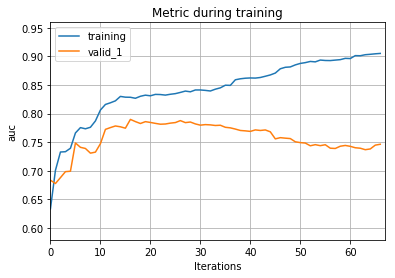

no 1-fold AUC: 0.7899014416004707
Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.795187	valid_1's auc: 0.651667
[20]	training's auc: 0.831392	valid_1's auc: 0.68078
[30]	training's auc: 0.860874	valid_1's auc: 0.71042
[40]	training's auc: 0.880132	valid_1's auc: 0.733369
[50]	training's auc: 0.892078	valid_1's auc: 0.718138
[60]	training's auc: 0.913435	valid_1's auc: 0.713965
[70]	training's auc: 0.918445	valid_1's auc: 0.713579
[80]	training's auc: 0.92855	valid_1's auc: 0.698053
Early stopping, best iteration is:
[32]	training's auc: 0.865825	valid_1's auc: 0.737594


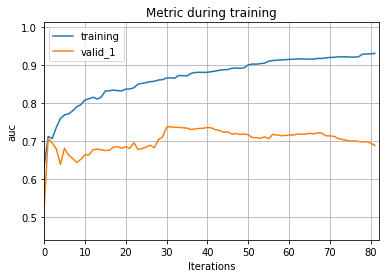

no 2-fold AUC: 0.7375943905070118
Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.765236	valid_1's auc: 0.720685
[20]	training's auc: 0.820297	valid_1's auc: 0.733521
[30]	training's auc: 0.858394	valid_1's auc: 0.747642
[40]	training's auc: 0.868279	valid_1's auc: 0.79237
[50]	training's auc: 0.891133	valid_1's auc: 0.779136
[60]	training's auc: 0.898677	valid_1's auc: 0.788091
[70]	training's auc: 0.908427	valid_1's auc: 0.77627
[80]	training's auc: 0.915656	valid_1's auc: 0.777838
Early stopping, best iteration is:
[35]	training's auc: 0.865074	valid_1's auc: 0.794105


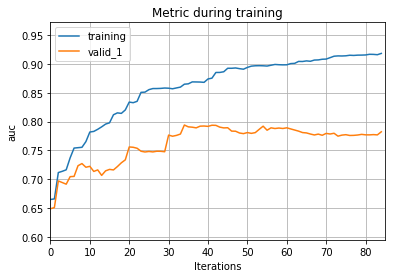

no 3-fold AUC: 0.7941047978824557
Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.802759	valid_1's auc: 0.636188
[20]	training's auc: 0.852508	valid_1's auc: 0.64801
[30]	training's auc: 0.864071	valid_1's auc: 0.657081
[40]	training's auc: 0.890611	valid_1's auc: 0.656143
[50]	training's auc: 0.898215	valid_1's auc: 0.652224
[60]	training's auc: 0.920818	valid_1's auc: 0.652533
[70]	training's auc: 0.927482	valid_1's auc: 0.656272
[80]	training's auc: 0.93684	valid_1's auc: 0.656387
[90]	training's auc: 0.941786	valid_1's auc: 0.646057
Early stopping, best iteration is:
[45]	training's auc: 0.8926	valid_1's auc: 0.662105


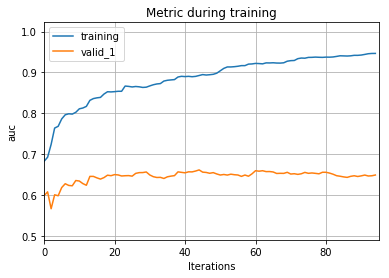

no 4-fold AUC: 0.6621052090560995
Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.823933	valid_1's auc: 0.723486
[20]	training's auc: 0.87745	valid_1's auc: 0.709711
[30]	training's auc: 0.893493	valid_1's auc: 0.710829
[40]	training's auc: 0.911608	valid_1's auc: 0.699972
[50]	training's auc: 0.920061	valid_1's auc: 0.695667
[60]	training's auc: 0.928033	valid_1's auc: 0.688112
Early stopping, best iteration is:
[12]	training's auc: 0.828842	valid_1's auc: 0.736206


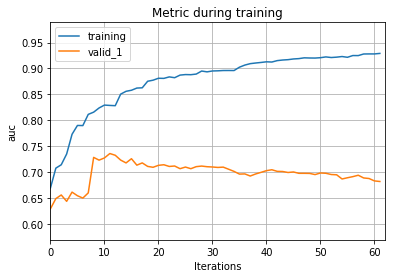

no 5-fold AUC: 0.7362064091691722
AUC : 0.73542


In [37]:
clfs, score, importances, oof_preds = model4JDFM_AUC(params, jdfm_tr, target, nr_fold=5, random_state=1)

In [38]:
importances.groupby('feature').mean().sort_values('gain', ascending = False)

,gain,fold
feature,,
weeks_from_start,9.0,3.0
6wDiffMean,6.8,3.0
1wDiffMean,6.2,3.0
diffPeakMax,6.0,3.0
9wDiffMean,4.8,3.0
ordered_product_sales,4.2,3.0
12wDiffMean,4.0,3.0
3wMean_of_12wDiffMean,4.0,3.0
2wDiffMean,3.6,3.0


In [39]:
jdfm_tr['preds'] = oof_preds
jdfm_tr['weeks_to_churn'] = target_ori
jdfm_tr['trend'] = trend

Text(0, 0.5, 'Probability of to churn')

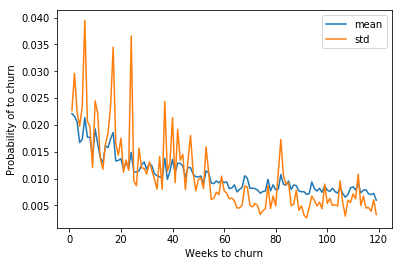

In [40]:
plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 120,:].groupby('weeks_to_churn').mean()['preds'])
plt.plot(jdfm_tr.loc[jdfm_tr.weeks_to_churn < 120,:].groupby('weeks_to_churn').std()['preds'])
plt.legend(['mean', 'std'])
plt.xlabel('Weeks to churn')
plt.ylabel('Probability of to churn')

AUC of .73 doesn't look awesome either and even though it's correlated with time to churn the STD is pretty high

In [41]:
t1 = jdfm_tr.loc[(jdfm_tr.weeks_to_churn > 0) & (jdfm_tr.trend == 1) & \
                  (jdfm.weeks_to_churn < 120),:].groupby('weeks_to_churn').mean()['6wDiffMean']
t2 = jdfm_tr.loc[(jdfm_tr.weeks_to_churn > 0) & (jdfm_tr.trend == 0) & \
                  (jdfm_tr.weeks_to_churn < 120),:].groupby('weeks_to_churn').mean()['6wDiffMean']
t3 = jdfm_tr.loc[(jdfm_tr.weeks_to_churn > 0) & (jdfm_tr.trend == 0) & \
                  (jdfm_tr.weeks_to_churn < 120),:].groupby('weeks_to_churn').mean()['preds']

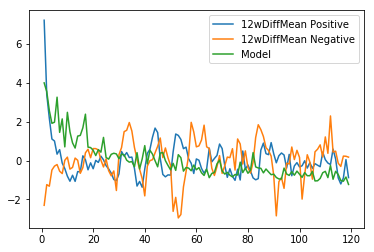

In [42]:
plt.plot((t1 - t1.mean()) / t1.std())
plt.plot((t2 - t2.mean()) / t2.std())
plt.plot((t3 - t3.mean()) / t3.std())
plt.legend(['12wDiffMean Positive','12wDiffMean Negative','Model'])

In comparison to trend KPI, the model doesn't get as high as 12wDiffMean when pointing out customers who had outgrown the company but is way more stable

Things to  try:
- Survival Analysis (it's similar problem)
- Data related to users which didn't convert yet
- NN LSTM
- Add other data about customer (category of sales)
- add monthly aggregations
- add YOY data
- add trend data without seasonality